# Documentation

This notebook contains structured lists of the methods and functions implemented in the `mcfa` package. If you are looking for a getting-started guide, refer to the `4d_gaussian.ipynb` notebook in the same directory.

The API of the `mcfa` package is designed in close resemblance to the `sklearn.mixture.GaussianMixture` implementation. The main interface is the `mcfa.MCFA` class. 

In [1]:
import mcfa

from sklearn.datasets import load_iris # used below for demonstration purposes only

2022-04-10 17:12:45.000428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-10 17:12:45.000455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-10 17:12:46.450783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-10 17:12:46.450804: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-10 17:12:46.450825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


There are three basic steps.

- initializing the model instance with hyperparameters
- training the model instance using gradient descent
- clustering data samples using the trained model instance

Further implemented are functions to store a model to disk, to initialize a model from disk, to visualize the training loss, and to impute the missing values in the input data.

## Instantiation

The hyperparameters of the MCFA model are the number of components (`n_components`) and the number of latent factors (`n_factors`). They are set when the model is instantiated.

In [2]:
model = mcfa.MCFA(n_components=3, n_factors=2)

## Training

The model is trained on the user-provided data `Y`. A second mandatory argument is the number of training epochs `n_epochs`. Optional arguments are

- `learning_rate`: Passed to the `tf.keras.optimizers.Adam` gradient-descent algorithm (`float`, default is `3e-4`)
- `batch_size`: Number of samples per batch during the gradient-descent training (`int`, default is `32`)
- `frac_validation`: Fraction of the input data to keep as validation set during training (`float`, default is `0.1`)
- `init_factors`: Method to use to instantiate the latent factors. Choose from `['pca', 'ppca']`. Default is `ppca`, which uses the entire input data for initialization using the [pyppca package](https://github.com/shergreen/pyppca). The `pca` initialization is performed on only the complete samples of the input data using the `sklearn.decomposition.PCA` function.

The latent components are always initialized using a Gaussian Mixture with the user-provided `n_components` fit to the latent scores after intializing the latent factors.

In [3]:
Y, _ = load_iris(return_X_y=True)
n_epochs = 1000

model.fit(Y, n_epochs, learning_rate=3e-4, batch_size=32, frac_validation=0.1, init_factors="ppca")

2022-04-10 17:12:46.538560: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Training :   0%|                                                                                                                               | 0/1000 [00:00<?, ?epoch/s]

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-04-10 17:12:47.415626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-10 17:12:47.453356: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz
Training : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.77epoch/s]


# Clustering

After training the model, any samples with the same features can be clustered and projected into the latent space. The latent scores `Z` are computed via the `transform` method.

The clustering is done using the `predict` and `predict_proba` methods. The former returns the most likely component for each passed sample, the latter returns the responsibility matrix $\tau$, containing the probability per component for each sample.

In [4]:
Z = model.transform(Y)  # latent scores
clusters = model.predict(Y)  # most likely component for each sample

# Other functions

## Imputation

The clustered data can be imputed using the trained model instance. The imputation follows Wang 2013, Equ. 10.

In [5]:
Y_imputed = model.impute(Y)  # impute missing values

## Monitoring the training loss

The following simple plotting methods are implemented to inspect the trained model parameters:

The implementations are quite simple and adapted to the example data. They might
have to be adapted for other data cases.

/home/max/astro/mcfa/mcfa/figures.py:96: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


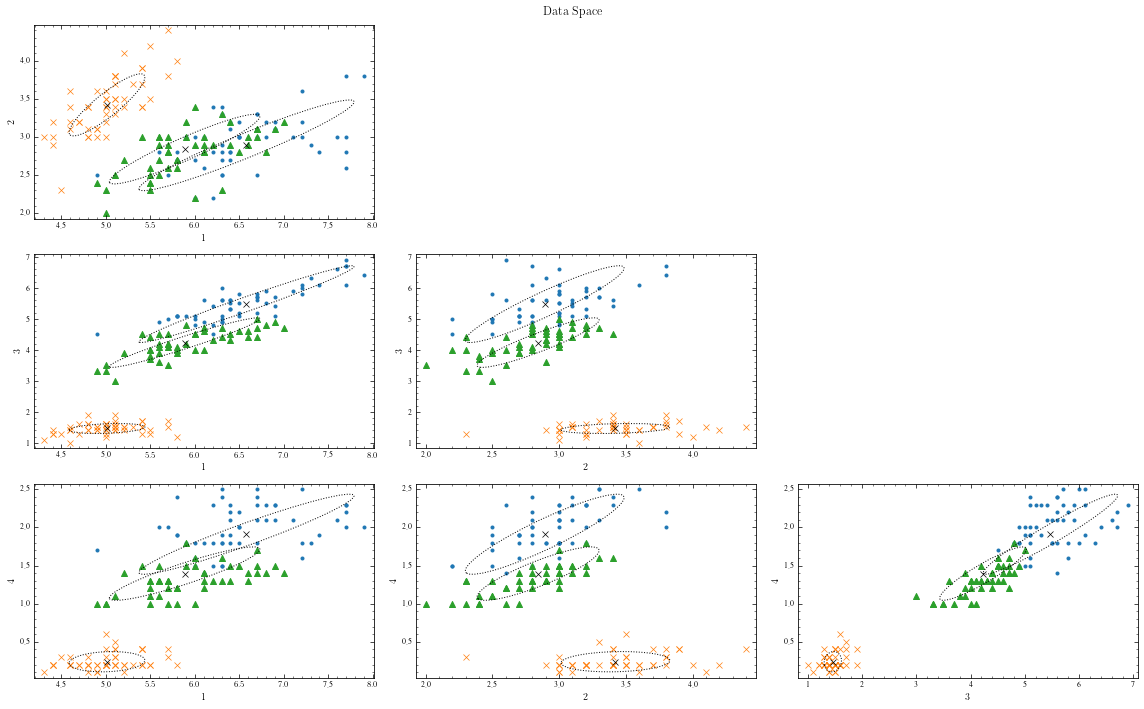

/home/max/astro/mcfa/mcfa/figures.py:177: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


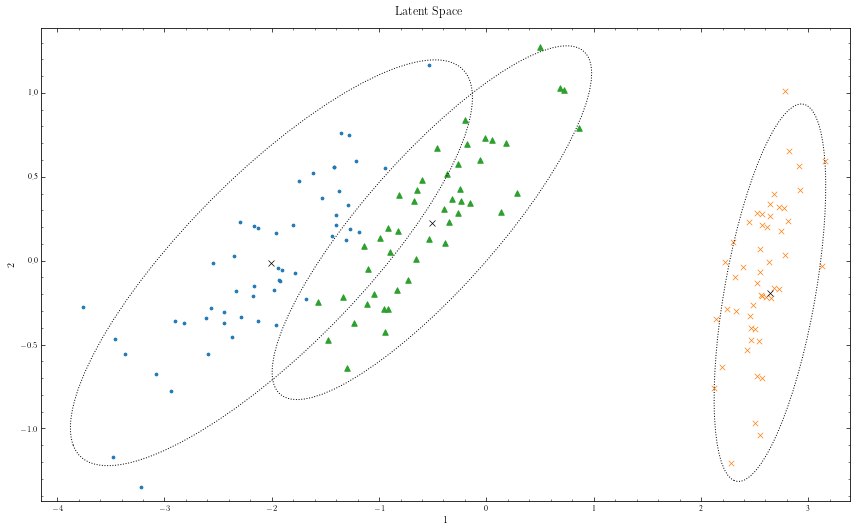

/home/max/astro/mcfa/mcfa/figures.py:199: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


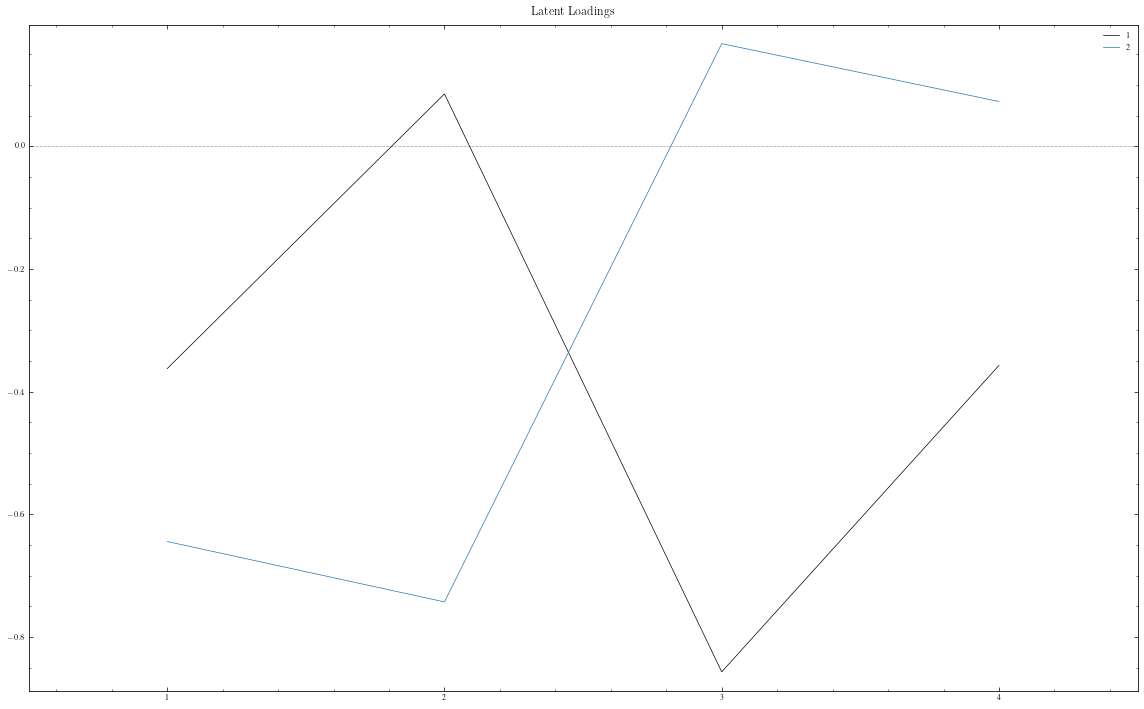

/home/max/astro/mcfa/mcfa/figures.py:214: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


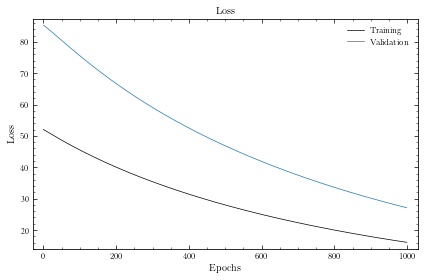

In [6]:
model.plot_data_space(Y, clusters=clusters)       # plot the data in the original space, coloured by the assigned
                              # cluster and superimposing the cluster ellipses
model.plot_latent_space(Z, clusters=clusters)     # plot the data in the latent space, coloured by the assigned
                              # cluster and superimposing the cluster ellipses
model.plot_latent_loadings()  # plot the latent loadings
model.plot_loss()             # plot the loss of the training and validation set

## Store to and read from file

Once the model has been trained, the relevant model parameters can be stored to disk and used to later instantiate the model without re-training. The parameters are stored in the pickle format, which is a binary format for `python` objects. It can be read with the `pickle` module. The stored object is a `dict` containing the model parameter names as keys and the respective values as values.

In [8]:
model.to_file("/tmp/output.pkl")
model = mcfa.from_file("/tmp/output.pkl")

# Note

## Limitations

- When initializing the latent factors with PCA, the data has to contain at least some complete rows.

- The value `0` is used as a marker for missing values in this implementation. If the observed features of an observation are all equal to zero, it is dropped. `0` has been chosen as it is simplifies the code.

## GPU vs CPU

If a GPU is available, `tensorflow` will automatically execute the model training
on it. To disable this behaviour, add the following before the `tensorflow` import.

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"